# Use an Hybrid approach

* **Authors**:

  * Author: steevelaquitaine@epfl.ch; laquitainesteeve@gmail.com
  * Adapted from notebooks by Steffen Schneider, Jin H Lee, Mackenzie Mathis.  
  * Duration: 1h min

* **Learning outcomes**:

  * know how to use CEBRA-Hybrid. We will test whether position and direction and time are encoded in the rat Hippocampus.

* **Readings**:

  * see [Figure 2](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) in Schneider, Lee, Mathis.

* **Python prerequisites**:

  * installing and importing `libraries`
  * plotting with `matplotlib` library

## (5m) Setup

1. Install `Cebra` with Python's pip software package manager (requires internet connection).
2. Import `software packages` (requires internet connection)

In [ ]:
import time
import locale
t0 = time.time()
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ipython-autotime # time track colab notebook cells
!pip install --pre 'cebra[datasets,demos]'
%load_ext autotime

In [ ]:
# import software packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

time: 10.8 s (started: 2024-03-14 14:26:19 +00:00)


## (1s) Loading the dataset

- The data will be automatically downloaded into a `/data` folder.

In [ ]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

100%|██████████| 10.0M/10.0M [00:00<00:00, 11.5MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'
time: 2.18 s (started: 2024-03-14 14:26:30 +00:00)


## (20s) Hypothesis-driven analysis

- We will compare CEBRA-Behavior and CEBRA-Hybrid models as in the recommended [CEBRA workflow](https://cebra.ai/docs/usage.html#the-cebra-workflow).

- We use an output dimension set to 3; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

### (20s) Hypothesis: behavioral position+direction

#### (1s) Parametrize

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [ ]:
max_iterations = 5000 #10000 #default is 5000.

cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 752 µs (started: 2024-03-14 14:26:32 +00:00)


#### (20s) Train the model

- We train the model <u>with neural data</u> and the <u>behavior variable</u> including position and direction.
- Train the model with 3D output that uses positional information (position + direction).
- Setting <u>conditional = 'time_delta'</u> means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.
- `hippocampus_pos.continuous_index.numpy()` contains both rat's position and direction information

In [ ]:
# train the model
cebra_behavior_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())

# save model
cebra_behavior_model.save("cebra_behavior_model.pt")

pos: -0.8959 neg:  6.4180 total:  5.5221 temperature:  1.0000: 100%|██████████| 5000/5000 [16:25<00:00,  5.07it/s]

time: 16min 28s (started: 2024-03-14 14:26:32 +00:00)


### (1s) Control

- We train a control model with shuffled neural data.
- The model specification is the same as the CEBRA-Behavior above.

#### (1s) Parametrize

In [ ]:
cebra_behavior_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 1.17 ms (started: 2024-03-14 14:43:01 +00:00)


#### (20s) Train the model

- Now we train the model with shuffled behavior variable.

In [ ]:
# Shuffle the behavior variable and use it for training
hippocampus_shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())

cebra_behavior_shuffled_model.fit(hippocampus_pos.neural, hippocampus_shuffled_posdir)
cebra_behavior_shuffled_model.save("cebra_behavior_shuffled_model.pt")

pos: -0.6687 neg:  6.8097 total:  6.1410 temperature:  1.0000: 100%|██████████| 5000/5000 [15:41<00:00,  5.31it/s]

time: 15min 41s (started: 2024-03-14 14:43:01 +00:00)



### (1s) Get the neural manifolds

In [ ]:
# CEBRA-Behavior
cebra_behavior_model = cebra.CEBRA.load("cebra_behavior_model.pt")
cebra_behavior = cebra_behavior_model.transform(hippocampus_pos.neural)

# CEBRA-Behavior with shuffled labels
cebra_behavior_shuffled_model = cebra.CEBRA.load("cebra_behavior_shuffled_model.pt")
cebra_behavior_shuffled = cebra_behavior_shuffled_model.transform(hippocampus_pos.neural)

time: 576 ms (started: 2024-03-14 14:58:42 +00:00)


### (1s) Plot

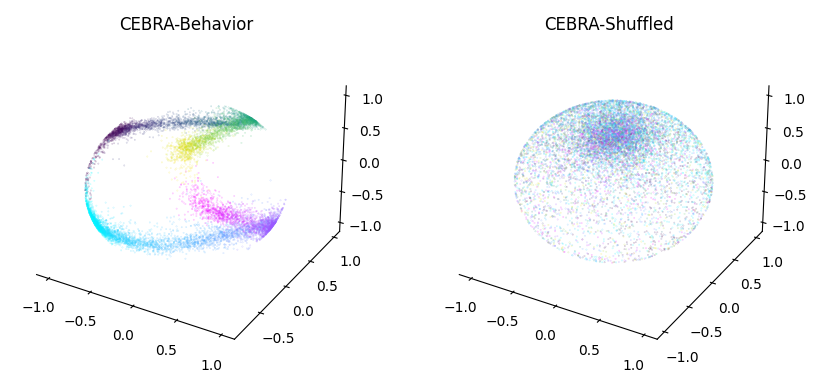

time: 792 ms (started: 2024-03-14 14:58:43 +00:00)


In [ ]:
%matplotlib inline

right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

# setup figure
fig = plt.figure(figsize=(10,5))

# create two panels
ax1 = plt.subplot(121, projection='3d')
ax2 = plt.subplot(122, projection='3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1 = cebra.plot_embedding(ax=ax1,
                               embedding=cebra_behavior[dir,:],
                               embedding_labels=hippocampus_pos.continuous_index[dir,0],
                               title='CEBRA-Behavior',
                               cmap=cmap
                               )
    ax2 = cebra.plot_embedding(ax=ax2,
                               embedding=cebra_behavior_shuffled[dir,:],
                               embedding_labels=hippocampus_pos.continuous_index[dir,0],
                               title='CEBRA-Shuffled', cmap=cmap
                               )

plt.show()

## () Hybrid approach

### (1s) Parametrize

In [ ]:
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

time: 733 µs (started: 2024-03-14 14:58:44 +00:00)


### (15m) Train the model

In [ ]:
cebra_hybrid_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_hybrid_model.save("cebra_hybrid_model.pt")

behavior_pos: -0.8848 behavior_neg:  6.4202 behavior_total:  5.5353 time_pos: -0.9193 time_neg:  6.4202 time_total:  5.5008: 100%|██████████| 5000/5000 [22:26<00:00,  3.71it/s]

time: 22min 26s (started: 2024-03-14 14:58:44 +00:00)


### (1s) Get the neural manifolds

In [ ]:
# CEBRA-Hybrid
cebra_hybrid_model = cebra.CEBRA.load("cebra_hybrid_model.pt")
cebra_hybrid = cebra_hybrid_model.transform(hippocampus_pos.neural)

time: 39.2 ms (started: 2024-03-14 15:21:11 +00:00)


### (1s) Plot

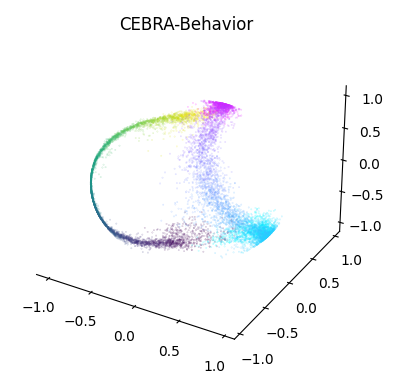

time: 339 ms (started: 2024-03-14 15:21:11 +00:00)


In [ ]:
%matplotlib inline

right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

# setup figure
fig = plt.figure(figsize=(10,5))

# create two panels
ax1 = plt.subplot(121, projection='3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1 = cebra.plot_embedding(ax=ax1,
                               embedding=cebra_hybrid[dir,:],
                               embedding_labels=hippocampus_pos.continuous_index[dir,0],
                               title='CEBRA-Behavior',
                               cmap=cmap
                               )

plt.show()

## Compare the manifolds

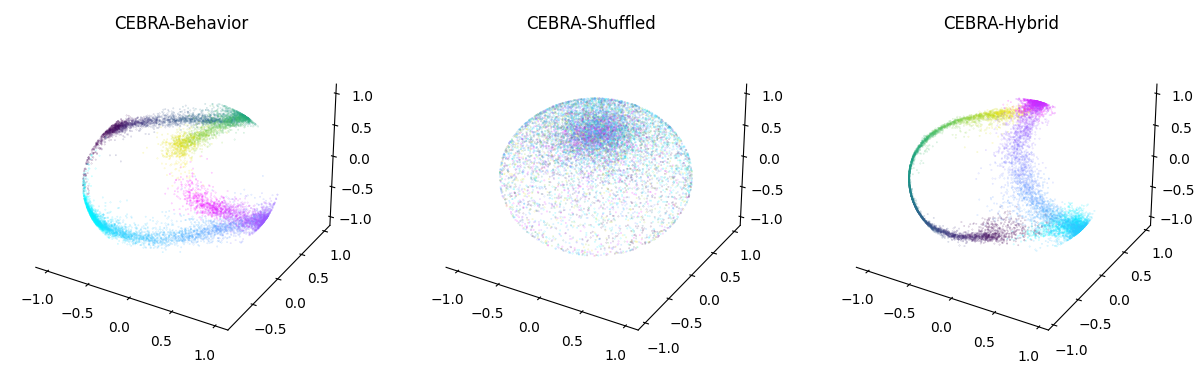

time: 1.04 s (started: 2024-03-14 15:21:11 +00:00)


In [ ]:
%matplotlib inline

right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

# setup figure
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(131, projection='3d')
ax2 = plt.subplot(132, projection='3d')
ax3 = plt.subplot(133, projection='3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_behavior[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Behavior', cmap=cmap)
    ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_behavior_shuffled[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Shuffled', cmap=cmap)
    ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_hybrid[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Hybrid', cmap=cmap)

plt.show()

In [ ]:
print("The notebook execution took:", np.round(time.time() - t0),1)

The notebook execution took: 3419.0 1
time: 2.4 ms (started: 2024-03-14 15:21:12 +00:00)
